# Sarsa

Implement Sarsa to learn how to play Tic-tac-toe against a random player. Produce a learning curve. Discuss the learning curves. The pseudo-code for SARSA is reproduced below from the textbook (Reinforcement Learning, Sutton & Barto, 1998, Section 6.4).
<img src="images/SARSA.png" style="width: 600px;"/>

### compare with Q-learning agent

The pseudo-code for Q-learning is reproduced below from the textbook (Reinforcement Learning, Sutton & Barto, 1998, Section 6.5).
<img src="images/q_learning.png" style="width: 600px;"/>

### Game Tic-Tac-Toe

Tic-Tac-Toe is a paper-and-pencil game for two players, O and X, who take turns marking the spaces in a 3×3 grid. The player who succeeds in placing three of their marks in a horizontal, vertical, or diagonal row wins the game. The following example game is won by player X (example from [Wikipedia](https://en.wikipedia.org/wiki/Tic-tac-toe)):
<img src="images/tic-tac-toe_WIKI.png" style="width: 600px;"/> 

In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Game Tic-Tac-Toe environment
class Board:
    def __init__(self, player_1, player_2):
        self.board = np.array([[' ', ' ', ' '], [' ', ' ', ' '], [' ', ' ', ' ']])
        self.player1_marker = player_1.marker
        self.player2_marker = player_2.marker
        self.active = False
        self.winner = None
    
    # get the possible choices for next step
    def get_possible_step(self):
        pos_step = []
        for i in itertools.product(np.arange(0,3),np.arange(0,3)):
            if self.board[i] == ' ':
                pos_step.append(i)
        return pos_step
   
    # print the current state of the board
    def print_board(self):
        print_cor = (((0,0),(0,1),(0,2)),((1,0),(1,1),(1,2)),((2,0),(2,1),(2,2)))
        for i in print_cor:
            print(self.board[i[0]] + '|' + self.board[i[1]] + '|' + self.board[i[2]])
    
    # check if the game is end
    def check(self):
        # check who is win
        win_conditions = (((0,0),(0,1),(0,2)),((1,0),(1,1),(1,2)),((2,0),(2,1),(2,2)),
                          ((0,0),(1,0),(2,0)),((0,1),(1,1),(2,1)),((0,2),(1,2),(2,2)),
                          ((0,0),(1,1),(2,2)),((0,2),(1,1),(2,0)))
        for each in win_conditions:
            if self.board[each[0]] == self.board[each[1]]  == self.board[each[2]]:
                if self.board[each[0]] != ' ':
                    self.winner = self.board[each[0]]
        
        if self.winner == self.player1_marker:
            player1_reward = 1
            player2_reward = -1
            self.active = False
            return player1_reward, player2_reward

        if self.winner == self.player2_marker:
            player1_reward = -1
            player2_reward = 1
            self.active = False
            return player1_reward, player2_reward
        
        # check if it's draw
        if len(self.get_possible_step()) == 0 and self.winner is None:
            player1_reward = 0
            player2_reward = 0
            self.active = False
            return player1_reward, player2_reward
        
        # if the game is not end 
        player1_reward = 0
        player2_reward = 0
        return player1_reward, player2_reward
    
    # make step function
    def make_step(self, player, step_coordinate):
        self.board[step_coordinate] = player.marker
        player1_reward, player2_reward = self.check()
        new_state = self.board
        
        return player1_reward, player2_reward, new_state
    
    # reset the game
    def reset_game(self):
        self.active = True
        self.winner = None
        self.board = np.array([[' ', ' ', ' '], [' ', ' ', ' '], [' ', ' ', ' ']])

In [3]:
# Random Agent
class random_agent:
    def __init__(self, marker):
        self.marker = marker
        
    def choose_step(self, board):
        pos_step = board.get_possible_step()
        chosen_step = pos_step[np.random.choice(len(pos_step))]
        return chosen_step

In [4]:
# Q Agent
class Q_Agent:
    def __init__(self, marker, alpha = 0.1, greedy = 0.1):
        self.marker = marker
        self.alpha = alpha
        self.greedy = greedy
        self.q = {}
    
    # get q value, if the key is not exist (since initial the q table as empty dictionary), initial its value as 0
    def getQ(self, state, step):
        if self.q.get((state, step)) is None:
            self.q[(state, step)] = 1
        return self.q.get((state, step))
    
    def choose_step(self, env):
        current_state = tuple(map(tuple, env.board))
        pos_step = env.get_possible_step()
        if np.random.rand(1) < self.greedy:
            # choose not greedy action 
            chosen_step = pos_step[np.random.choice(len(pos_step))]
        else:
            # choose greedy action according to Q table
            # get the maximum Q value of the current state
            max_q = np.array([self.getQ(current_state, p_step) for p_step in pos_step]).max()
            # create= a current dictionary which is a part of Q table to avoid of different state, but same q value
            current_key = [(current_state, p_step) for p_step in pos_step]
            new_d = {key:self.q[key] for key in current_key}
            # choose the action, if there are several actions, choose randomly
            choices = [key for key in new_d.keys() if new_d[key]==max_q]  
            chosen_step = choices[np.random.choice(len(choices))][1]
            
        return chosen_step
    
    def Q_learn(self, old_state, new_state, step, reward, pos_step_after):
        old_state = tuple(map(tuple, old_state))
        new_state = tuple(map(tuple, new_state))
        if len(pos_step_after) == 0:
            pass
        else:
            max_value = np.array([self.getQ(new_state, p_step) for p_step in pos_step_after]).max()
            self.q[(old_state,step)] = (1-self.alpha)*self.getQ(old_state,step)+self.alpha*(reward+max_value)

In [5]:
# Sarsa Agent
class Sarsa_Agent:
    def __init__(self, marker, alpha = 0.1, greedy = 0.1):
        self.marker = marker
        self.alpha = alpha
        self.greedy = greedy
        self.q = {}
    
    # get q value, if the key is not exist (since initial the q table as empty dictionary), initial its value as 0
    def getQ(self, state, step):
        if self.q.get((state, step)) is None:
            self.q[(state, step)] = 1
        return self.q.get((state, step))
    
    def choose_step(self, env):
        current_state = tuple(map(tuple, env.board))
        pos_step = env.get_possible_step()
        if len(pos_step) == 0:
            # chose (3,3) as an unexist step in the game, just to make the program pass
            chosen_step = (3,3)
        elif np.random.rand(1) < self.greedy:
            # choose not greedy action 
            chosen_step = pos_step[np.random.choice(len(pos_step))]
        else:
            # choose greedy action according to Q table
            # get the maximum Q value of the current state
            max_q = np.array([self.getQ(current_state, p_step) for p_step in pos_step]).max()
            # create a current dictionary which is a part of Q table to avoid of different state, but same q value
            current_key = [(current_state, p_step) for p_step in pos_step]
            new_d = {key:self.q[key] for key in current_key}
            # choose the action, if there are several actions, choose randomly
            choices = [key for key in new_d.keys() if new_d[key]==max_q]  
            chosen_step = choices[np.random.choice(len(choices))][1]
            
        return chosen_step
    
    def Sarsa_learn(self, old_state, new_state, old_step, new_step, reward):
        old_state = tuple(map(tuple, old_state))
        new_state = tuple(map(tuple, new_state))
        mask1 = self.getQ(old_state, old_step)
        mask2 = self.alpha * (reward + self.getQ(new_state, new_step) - mask1)
        self.q[(old_state,old_step)] = mask1 + mask2

In [6]:
# define a function that simulate Q learning
def simulate_game_Q(player_1, player_2, eposides):
    # asumme player_1 is always the Q-learning Agent
    env = Board(player_1, player_2)
    player_1_record = np.zeros(eposides)
    player_2_record = np.zeros(eposides)
    player_1_total = 0
    player_2_total = 0
    for eposide in range(eposides): 
        
        env.reset_game()
        # switch player
        player_first, player_second = (player_1, player_2) if np.random.choice(2) == 0 else (player_2, player_1)
        # play the game
        while env.active == True:
            temp_reward = 0
            old_state = env.board.copy()
            player_first_step = player_first.choose_step(env)
            player_1_reward, player_2_reward, new_state = env.make_step(player_first, player_first_step)
            temp_reward += player_1_reward
            player_1_total += player_1_reward
            player_2_total += player_2_reward
            if env.active == True:
                player_second_step = player_second.choose_step(env)
                player_1_reward, player_2_reward, new_state = env.make_step(player_second, player_second_step)
                temp_reward += player_1_reward
                player_1_total += player_1_reward
                player_2_total += player_2_reward
                pos_step_after = env.get_possible_step()
                # check wihich player is q player
                if player_1 == player_first:                 
                    player_1.Q_learn(old_state, new_state, player_first_step, temp_reward, pos_step_after)
                else:
                    player_1.Q_learn(old_state, new_state, player_second_step, temp_reward, pos_step_after)
            else:
                pos_step_after = env.get_possible_step()
                # check which player is q player
                if player_1 == player_first:                 
                    player_1.Q_learn(old_state, new_state, player_first_step, temp_reward, pos_step_after)
                else:
                    player_1.Q_learn(old_state, new_state, player_second_step, temp_reward, pos_step_after)
                    
        player_1_record[eposide] = player_1_total
        player_2_record[eposide] = player_2_total
        
    return player_1_record, player_2_record

In [7]:
# define a function that used to simulate Sarsa
def simulate_game_Sarsa(player_1, player_2, eposides):
    # asumme player_1 is always the SARSA Agent
    env = Board(player_1, player_2)
    player_1_record = np.zeros(eposides)
    player_2_record = np.zeros(eposides)
    player_1_total = 0
    player_2_total = 0
    for eposide in range(eposides): 
        env.reset_game()
        # switch player
        if np.random.choice(2) == 0: # when player 1 go first
            old_player_1_step = player_1.choose_step(env)           
        else:  # when player 2 go fisrt
            player_2_step = player_2.choose_step(env)
            player_1_reward, player_2_reward, _ = env.make_step(player_2, player_2_step)
            player_1_total += player_1_reward
            player_2_total += player_2_reward
            old_player_1_step = player_1.choose_step(env)
        # play the game
        while env.active == True:
            temp_reward = 0
            old_state = env.board.copy()
            player_1_reward, player_2_reward, new_state = env.make_step(player_1, old_player_1_step)
            temp_reward += player_1_reward
            player_1_total += player_1_reward
            player_2_total += player_2_reward 
            if env.active == True:
                player_2_step = player_2.choose_step(env)
                player_1_reward, player_2_reward, new_state = env.make_step(player_2, player_2_step)
                temp_reward += player_1_reward
                player_1_total += player_1_reward
                player_2_total += player_2_reward
                new_player_1_step = player_1.choose_step(env)
                player_1.Sarsa_learn(old_state, new_state, old_player_1_step, new_player_1_step, 
                                     temp_reward)
                old_player_1_step = new_player_1_step
            else:
                # chose (3,3) as an unexist step in the game, just to make the program pass
                new_player_1_step = (3,3)
                player_1.Sarsa_learn(old_state, new_state, old_player_1_step, new_player_1_step, 
                                     temp_reward)
                    
        player_1_record[eposide] = player_1_total
        player_2_record[eposide] = player_2_total
        
    return player_1_record, player_2_record

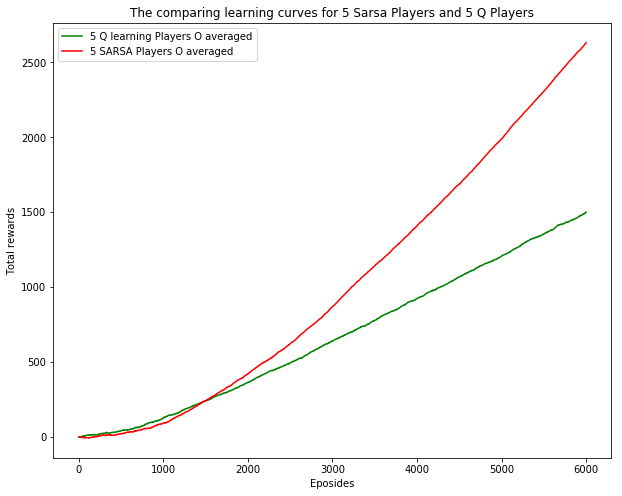

In [8]:
player_random = random_agent('X')
eposides = 6000
player_Q_record = []
player_SARSA_record = []
for i in range(5):
    player_Q = Q_Agent('O')
    player_SARSA = Sarsa_Agent('O')
    
    player_Q_record.append(simulate_game_Q(player_Q, player_random, eposides)[0])
    player_SARSA_record.append(simulate_game_Sarsa(player_SARSA, player_random, eposides)[0])

fig = plt.figure(figsize=(10, 8))

plt.plot(np.arange(eposides), np.array(player_Q_record).mean(axis = 0), color = 'g', 
         label = '5 Q learning Players O averaged')
plt.plot(np.arange(eposides), np.array(player_SARSA_record).mean(axis = 0), color = 'r', 
         label = '5 SARSA Players O averaged')


plt.legend(loc = 'best')
plt.xlabel('Eposides')
plt.ylabel('Total rewards')
plt.title('The comparing learning curves for 5 Sarsa Players and 5 Q Players')
plt.show()